# Workspace \#9: ``emcee``

In [1]:
# %load firstcell.py
# autoreloading for imported modules
%load_ext autoreload
%autoreload 2

# getting future division
from __future__ import division

# numpy
import numpy as np
from numpy import pi, sqrt, log, log10, power, exp

#scipy
from scipy.interpolate import interp1d

# matplotlib
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import rc
from matplotlib.lines import Line2D

# other
import os
from tqdm import tqdm

# matplotlib style
%matplotlib inline

%config InlineBackend.figure_format = "retina"
rcParams['figure.figsize'] = (13, 8)
rcParams['font.family'] = 'serif'
rcParams['font.serif'] = ['New Times Roman']
rc('text', usetex=True)

# current directory
current_dir = os.getcwd()

In [2]:
from random import random, choice

import sys
sys.path.insert(0, '../')

import constants as ct
import particle as pt
import astro as ap
import echo as ec
import routines as rt
import data as dt
import model as md

/home/buenabad/anaconda2/lib/python2.7/site-packages/healpy/fitsfunc.py:352: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  "If you are not specifying the input dtype and using the default "
/home/buenabad/anaconda2/lib/python2.7/site-packages/healpy/fitsfunc.py:403: UserWarning: No INDXSCHM keyword in header file : assume IMPLICIT
  warnings.warn("No INDXSCHM keyword in header file : " "assume {}".format(schm))


NSIDE = 512
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING


In [3]:
# Important quantities for aberration estimate
solar_period = 2.4e8 # [years]
solar_mw_radius = ct._Sun_to_gal_center_ # [kpc]

## 1. Preparing Green's Catalog

In [4]:
# first let's parse snrs.list.html
# names:
snr_name_arr = dt.load_Green_catalogue_names()

# catalogue:
snrs_dct = dt.load_Green_catalogue(snr_name_arr, verbose=0)

G4.5+6.8 is suggested to be related to SN explosion at AD:1604
it is about 417 years old.
G7.7-3.7 is suggested to be related to SN explosion at AD:386
it is about 1635 years old.
G11.2-0.3 is suggested to be related to SN explosion at AD:386
it is about 1635 years old.
G69.0+2.7 is suggested to be related to SN explosion at AD:1408
it is about 613 years old.
G111.7-2.1 could be related to  a late 17th century SN.
it is about 321 years old.
G120.1+1.4 is suggested to be related to SN explosion at AD:1572
it is about 449 years old.
G130.7+3.1 is suggested to be related to SN explosion at AD:1181
it is about 840 years old.
G184.6-5.8 is suggested to be related to SN explosion at AD:1054
it is about 967 years old.
G315.4-2.3 is suggested to be related to SN explosion at AD:185
it is about 1836 years old.
G320.4-1.2 is suggested to be related to SN explosion at AD:185
it is about 1836 years old.
G327.6+14.6 is suggested to be related to SN explosion at AD:1006
it is about 1015 years old.


In [5]:
snrs_cut = {}
for name, snr in snrs_dct.items():
    
    try:
        snr.distance
    except:
#         print "no distance:", name
        continue
    
    try:
        snr.alpha
    except:
        continue
    
    if snr.get_flux_density() == -1:
        print "no flux density:", name
        continue
    
    if not snr.is_flux_certain:
        print "uncertain flux:", name
        continue
    
    snrs_cut[name] = snr
    
print len(snrs_cut)

uncertain flux: G49.2-0.7
uncertain flux: G39.7-2.0
no flux density: G85.9-0.6
no flux density: G181.1+9.5
uncertain flux: G344.7-0.1
uncertain flux: G32.8-0.1
uncertain flux: G327.4+0.4
uncertain flux: G330.2+1.0
uncertain flux: G82.2+5.3
uncertain flux: G316.3-0.0
uncertain flux: G350.1-0.3
uncertain flux: G320.4-1.2
uncertain flux: G5.4-1.2
no flux density: G85.4+0.7
61


In [6]:
from scipy.interpolate import RectBivariateSpline as RBS
from scipy.interpolate import interp2d

# TODO: edit accordingly to read everything from the correct path.
# green path
green_path = "/home/buenabad/Documents/Physics/Projects/P11 - 2021 - snr_ghosts/green_snr/"

# loading pre-computed arrays
pre_Lpk_arr = np.loadtxt(green_path+"Lpk_arr.txt", delimiter=",")
pre_tpk_arr = np.loadtxt(green_path+"tpk_arr.txt", delimiter=",")

# peak luminosity and time grids
pre_Lpk_Gr, pre_tpk_Gr = np.meshgrid(pre_Lpk_arr, pre_tpk_arr, indexing='xy')

# normal (0, 1) variables from pre-computed arrays:
normal_Lpk_arr = (log10(pre_Lpk_arr)-ct._mu_log10_Lpk_)/ct._sig_log10_Lpk_
normal_tpk_arr = (log10(pre_tpk_arr)-ct._mu_log10_tpk_)/ct._sig_log10_tpk_

# sigmas contours on pre-computed grids
sigs_Gr = np.sqrt(((log10(pre_Lpk_Gr)-ct._mu_log10_Lpk_)/ct._sig_log10_Lpk_)**2 + ((log10(pre_tpk_Gr)-ct._mu_log10_tpk_)/ct._sig_log10_tpk_)**2)


def load_green_results(name, tt=(None, None), t_extra=0., nuB=1.):
    """
    Function that loads the CCV numerical results for the SNRs from Green's Catalog.
    
    TODO: edit accordingly to read them from the correct path.
    """
    
    if not name in snrs_cut.keys():
        raise ValueError("name={} not available in results.".format(name))
    
    if type(tt) != tuple:
        raise ValueError("Argument 'tt', of how to deal with the transition time 't_trans' must be a 2-tuple, of the form ('method', #), 'method' being either 'fixed'/'ratio'.")
    
    if not tt[0] in ["fixed", "ratio"]:
        raise ValueError("tt[0] can only be 'fixed' or 'ratio'")
    
    if t_extra == 0.:
        tex_str = ""
    else:
        tex_str = "_tex-"+str(int(t_extra))
    
    if nuB == 1.:
        nuB_str = ""
    else:
        nuB_str = "_nuB-{}".format(int(nuB))
    
    folder = green_path+name+"/"
    file = "{}_Lpk-tpk_{}-{}{}{}.txt".format(name, tt[0], int(tt[1]), tex_str, nuB_str)
    
    sn = np.loadtxt(folder+"sn_"+file, delimiter=",")
    echo = np.loadtxt(folder+"echo_"+file, delimiter=",")
    tage = np.loadtxt(folder+"tage_"+file, delimiter=",")
    
    return sn, echo, tage

## 2. Reach function

In [36]:
ma_ref

8.27133561166016e-06

In [7]:
# energetics and axion parameters
nu_pivot = 1. # [GHz]
ma_ref = pt.ma_from_nu(nu_pivot)
ga_ref = 1.e-10

def snr_reach(name, tt=(None, None), nuB=1., t_extra=0., sn_ratio_threshold=1., variables='normal', full_output=True):
    """
    Returns an interpolated function of the discovery reach of the axion-photon coupling ga [GeV^-1] as a function of the Bietenholz parameters (be that in terms of normalized (0, 1) variables (variables='normal'), or in terms of the raw parameters t_peak and L_peak themselves) for a certain signal-to-noise ratio and SNR name. If full_output == True, it also returns other important quantities.
    """
    
    if tt[0] == "ratio":
        tt_ratio = tt[1]
    elif tt[0] == "fixed":
        t_trans = tt[1]
    
    snr = snrs_cut[name]
    
    # SNR properties:
    alpha = snr.alpha
    gamma = ap.gamma_from_alpha(alpha)
    S0 = snr.get_flux_density() # [Jy] spectral irrad. today
    distance = snr.distance # [kpc]
    area = 4.*pi*(distance*ct._kpc_over_cm_)**2. # [cm^2]
    L0 = (S0*ct._Jy_over_cgs_irrad_)*area # [cgs]
    size = snr.sr
    
    # SNR results
    sn_Gr, _, _ = load_green_results(name, tt=tt, t_extra=t_extra, nuB=nuB)

    # going from Bietenholz peak Luminosities to pivot luminosities (at 1 GHz):
    # conversion factor:
    from_Bieten_to_pivot = (nu_pivot/nuB)**-alpha
    # copying arrays and grids:
    Lpk_arr, tpk_arr = np.copy(pre_Lpk_arr), np.copy(pre_tpk_arr)
    Lpk_Gr, tpk_Gr = np.copy(pre_Lpk_Gr), np.copy(pre_tpk_Gr)
    # correcting with conversion factor:
    Lpk_arr *= from_Bieten_to_pivot
    Lpk_Gr *= from_Bieten_to_pivot
    
    # limiting parameter space:
    # non-sensical lightcurve suppression:
    sup_arr = L0/Lpk_arr
    sup_Gr = L0/Lpk_Gr
    normal_Lpk_cut = (log10(L0/from_Bieten_to_pivot)-ct._mu_log10_Lpk_)/ct._sig_log10_Lpk_
    # masking nonsensical suppression parameters
    masked_normal_Lpk_arr = normal_Lpk_arr[sup_arr < 1.]
    masked_Lpk_arr = Lpk_arr[sup_arr < 1.]
    masked_sn_Gr = sn_Gr[sup_Gr < 1.]
    
    masked_sn_Gr = masked_sn_Gr.reshape(len(normal_tpk_arr), len(masked_normal_Lpk_arr))
    
    ga_Gr = ec.ga_reach(sn_ratio_threshold, masked_sn_Gr, ga_ref)
    ga_Gr = np.nan_to_num(ga_Gr)
    
    if variables == 'normal':
        
        def ga_fn(nL, nt): return 10.**interp2d(masked_normal_Lpk_arr, normal_tpk_arr, log10(ga_Gr))(nL, nt)
    
    elif variables == 'raw':
        
        def ga_fn(Lpk, tpk): return 10.**interp2d(log10(masked_Lpk_arr), log10(tpk_arr), log10(ga_Gr))(log10(Lpk), log10(tpk))
    
    if full_output:
        if variables == 'normal':
            return ga_fn, ga_Gr, masked_normal_Lpk_arr, normal_tpk_arr, normal_Lpk_cut
        elif variables == 'raw':
            return ga_fn, ga_Gr, masked_Lpk_arr, tpk_arr, L0
    else:
        return ga_fn

In [8]:
# name = choice(snrs_cut.keys())
name = 'G114.3+0.3'

ga_fn, ga_Gr, nL_arr, nt_arr, nL_cut = snr_reach(name, tt=("ratio", 30.), nuB=8., t_extra=0., sn_ratio_threshold=2., variables='normal', full_output=True)

print ga_Gr.shape, nL_arr.shape, nt_arr.shape
print nL_cut

print ga_fn(sqrt(0),sqrt(0)), ga_fn(sqrt(2),sqrt(2))

# del name, ga_fn, ga_Gr, nL_arr, nt_arr, nL_cut

(101, 102) (102,) (101,)
-2.9620459726215196
[1.34360648e-09] [4.26405932e-11]


../echo.py:1019: RuntimeWarning: divide by zero encountered in true_divide
  return ga_ref * sqrt(sn_val/sn_ref)


## 3. SNR ``emcee`` analysis

In [10]:
import emcee

In [11]:
def normal_prior(x, limits):
    
    return np.nan_to_num((-np.inf)*np.logical_not(np.heaviside(x-limits[0], 1.)*np.heaviside(limits[1]-x, 1.)))

def log_likelihood(nL, nt):
    return -0.5*(nL**2. + nt**2.)

def log_posterior(nL, nt, nL_limits, nt_limits, blob_fn):
    
    nL_prior = normal_prior(nL, nL_limits)
    nt_prior = normal_prior(nt, nt_limits)
    loglkl = log_likelihood(nL, nt)
    
    posterior = nL_prior + nt_prior + loglkl
    
    blob = blob_fn(nL, nt)[0]
    
    return posterior, blob

In [12]:
log_posterior(2., 0., (-2, 2), (-2, 2), ga_fn)

/home/buenabad/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in multiply
  This is separate from the ipykernel package so we can avoid doing imports until


(-2.0, 3.928314755992905e-11)

In [23]:
output_dir = {}

def snr_emcee_routine(name, tt=(None, None), nuB=1., t_extra=0., sn_ratio_threshold=1.,
                     nL_limits=(None, None), nt_limits=(None, None),
                     nwalkers=50, nburn=200, nsteps=2000, output_dir={}):
    
    ga_fn, _, _, _, nL_cut = snr_reach(name, tt=tt, nuB=nuB, t_extra=t_extra,
                                       sn_ratio_threshold=sn_ratio_threshold,
                                       variables='normal', full_output=True)
    # updating nL prior
    new_nL_limits = (max(nL_limits[0], nL_cut), nL_limits[1])
    
    # limits of the priors
    nL_center, nL_size = np.mean(new_nL_limits), new_nL_limits[1] - new_nL_limits[0]
    nt_center, nt_size = np.mean(nt_limits), nt_limits[1] - nt_limits[0]
    
    # two dimensions
    ndim = 2
    
    # starting guesses
    p0 = np.random.rand(nwalkers, ndim)-0.5
    # for normalized Lpk:
    p0[:,0] *= nL_size # with correct size...
    p0[:,0] += nL_center # ... and center
    # for normalized tpk:
    p0[:,1] *= nt_size # with correct size...
    p0[:,1] += nt_center # ... and center
    
    # preparing the data type of the blobs
    dtype = [("ga_reach", float)]
    
    # defining the posterior probability
    def log_post(x):
        return log_posterior(x[0], x[1], new_nL_limits, nt_limits, ga_fn)
    
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_post,
                                    blobs_dtype=dtype)
    sampler.run_mcmc(p0, nsteps)
    
    sample = sampler.chain # shape = (nwalkers, nsteps, ndim)
    sample = sampler.chain[:, nburn:, :] # discard burn-in points
    sample = sample.reshape(-1, ndim)
    
    blobs = sampler.get_blobs()
    ga_reach = blobs["ga_reach"]
    
    ga_reach = ga_reach[nburn:,:].ravel()
    
    output_dir[name] = sample, ga_reach
    
    return sample, ga_reach

In [24]:
name = 'G114.3+0.3'
# name = choice(snrs_cut.keys())
tt = ("ratio", 30.)
nuB = 8.
t_extra = 0.
sn_th = 2.
nL_lim = (-2., 2.)
nt_lim = (-2., 2.)

# np.random.seed(1)  # for repeatability

sample, ga_reach = snr_emcee_routine(name,
                                     tt=tt, nuB=nuB, t_extra=t_extra,
                                     sn_ratio_threshold=sn_th,
                                     nL_limits=nL_lim,
                                     nt_limits=nt_lim,
                                     nwalkers=50,
                                     nburn=1000,
                                     nsteps=5000,
                                     output_dir=output_dir)

/home/buenabad/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in multiply
  This is separate from the ipykernel package so we can avoid doing imports until
/home/buenabad/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: overflow encountered in power
/home/buenabad/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in double_scalars
  


/home/buenabad/.local/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/buenabad/.local/lib/python2.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family [u'serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


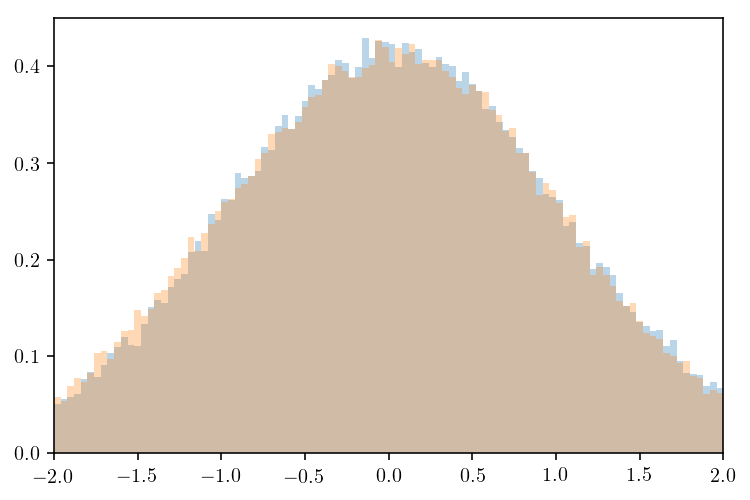

In [27]:
name = 'G114.3+0.3'
sample, ga_reach = output_dir[name]

plt.hist(sample[:,0], bins=100, histtype="stepfilled", alpha=0.3, normed=True)
plt.hist(sample[:,1], bins=100, histtype="stepfilled", alpha=0.3, normed=True)

plt.xlim(-2., 2.);

6.57484714401426e-11 1.285443246436635e-09 2.4123649391015345e-08


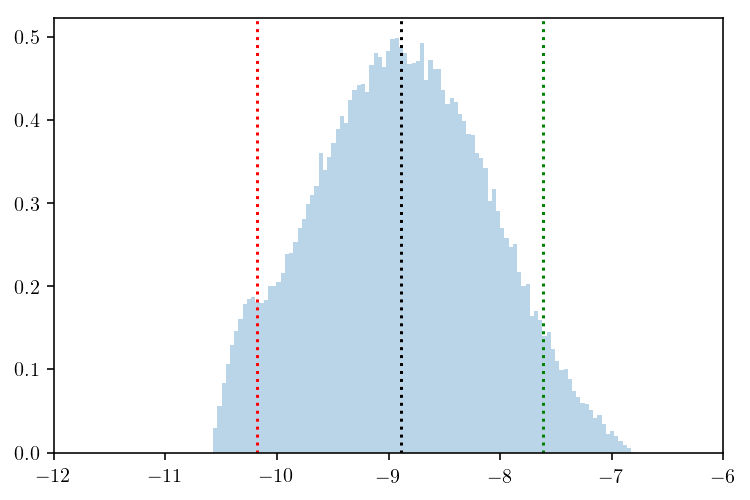

In [37]:
simple_ga = np.nan_to_num(ga_reach)
simple_ga = simple_ga[simple_ga < 1.e-2]

plt.hist(log10(simple_ga), bins=100, histtype="stepfilled", alpha=0.3, normed=True)
# plt.xscale("log")
plt.xlim(-12, -6);

# ga_m1s, ga_0s, ga_p1s = np.quantile(simple_ga, 0.159), np.quantile(simple_ga, 0.5), np.quantile(simple_ga, 0.841)
ga_m1s, ga_0s, ga_p1s = np.quantile(simple_ga, 0.05), np.quantile(simple_ga, 0.5), np.quantile(simple_ga, 0.95)

print ga_m1s, ga_0s, ga_p1s

plt.axvline(log10(ga_m1s), ls=":", color="r");
plt.axvline(log10(ga_0s), ls=":", color="k");
plt.axvline(log10(ga_p1s), ls=":", color="g");

## **TO DO:**
### 1. ``emcee`` exercise
### 2. routine for transforming S/N to ga_reach for a given SNR; interpolate ga_reach fit function
### 3. ``emcee`` to extract ga_reach PDF from Bietenholz dist. for a given SNR grid:
a) make sure priors on parameters make physical sense

b) do not fall outside the interpolation grid

c) scanned over log10 rather than linear (?)

In [10]:
import emcee

In [19]:
from scipy import stats
np.random.seed(1)  # for repeatability

F_true = 1000  # true flux, say number of photons measured in 1 second
N = 50 # number of measurements
F = stats.poisson(F_true).rvs(N)  # N measurements of the flux
e = np.sqrt(F)  # errors on Poisson counts estimated via square root

In [36]:
def log_prior(theta):
    return 1  # flat prior

def log_likelihood(theta, F, e):
    return -0.5 * np.sum(log(2 * pi * e ** 2)
                         + (F - theta[0]) ** 2 / e ** 2)

def log_posterior(theta, F, e):
    
    l_post = log_prior(theta) + log_likelihood(theta, F, e)
    th = theta
    th2 = theta**2.
    
    return l_post, th, th2

In [37]:
ndim = 1  # number of parameters in the model
nwalkers = 50  # number of MCMC walkers
nburn = 1000  # "burn-in" period to let chains stabilize
nsteps = 2000  # number of MCMC steps to take

# we'll start at random locations between 0 and 2000
starting_guesses = 2000 * np.random.rand(nwalkers, ndim)

dtype = [("theta", float), ("theta2", float)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=[F, e], blobs_dtype=dtype)
sampler.run_mcmc(starting_guesses, nsteps)

sample = sampler.chain  # shape = (nwalkers, nsteps, ndim)
sample = sampler.chain[:, nburn:, :].ravel()  # discard burn-in points

In [66]:
blobs = sampler.get_blobs()
theta_samps = blobs["theta"]
theta2_samps = blobs["theta2"]

theta_samps = theta_samps[nburn:,:].ravel()
theta2_samps = theta2_samps[nburn:,:].ravel()

print theta_samps.shape, theta2_samps.shape

(50000,) (50000,)


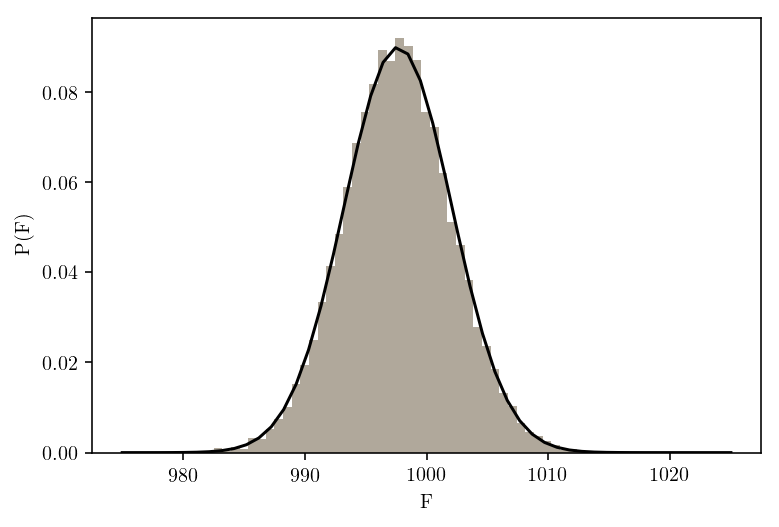

In [73]:
# plot a histogram of the sample
plt.hist(sample, bins=50, histtype="stepfilled", alpha=0.5, normed=True)
plt.hist(theta_samps, bins=50, histtype="stepfilled", alpha=0.3, normed=True)

# plot a best-fit Gaussian
F_fit = np.linspace(975, 1025)
pdf = stats.norm(np.mean(sample), np.std(sample)).pdf(F_fit)

plt.plot(F_fit, pdf, '-k')
plt.xlabel("F"); plt.ylabel("P(F)");